## Input data requirements

The input ice sheet model should be saved as a netCDF file. There are several requirements for the comparison:

### `Lithk` variable

The uploaded model to contain thickness data (the `lithk` variable) for the comparison.

### Rectangular grid

At time of writing, models *must* be defined on a rectangular X-Y grid in the ISMIP6 standard projected polar-stereographic space. (Note, NOT a lat-lon grid!) The ISMIP6 standard projection is defined [here](http://www.climate-cryosphere.org/wiki/index.php?title=ISMIP6_wiki_page). 


In [1]:
# set geospatial python3 kernel to provide needed packages
import os,sys
import glob as glob
import numpy as np
import h5py
import xarray as xr
import glob as glob


import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
# from matplotlib import rc
# rc('mathtext', default='regular')

sys.path.insert(0, os.path.abspath('..'))


# note: suppress numpy.dtype size changed warnings
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

warnings.filterwarnings('ignore')

In [2]:
# nc_filename='/home/jovyan/CmCt/notebooks/Gravimetry/lithk_GIS_JPL_ISSM_asmb.nc'
# nc_filename='/home/jovyan/CmCt/notebooks/Gravimetry/lithk_AIS_IMAU_IMAUICE1_hist_std.nc'

nc_filename='/home/jovyan/CmCt/notebooks/Gravimetry/lithk_AIS_AWI_PISM1_hist_std.nc'

# shapefile_path = "/home/jovyan/CmCt/notebooks/IMBIE/Greenland_Basins_PS_v1.4.2/Greenland_Basins_PS_v1.4.2.shp"
shapefile_path = "/home/jovyan/CmCt/notebooks/IMBIE/ANT_Basins_IMBIE2_v1.6/ANT_Basins_IMBIE2_v1.6.shp"


In [3]:
import xarray as xr
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import cftime  # Ensure cftime is imported

# Load the dataset(model data)
gis_ds = xr.open_dataset(nc_filename)
lithk = gis_ds['lithk']

#################
# # Define start and end dates
# start_date = np.datetime64('2000-01-01')
# end_date = np.datetime64('2015-01-01')

# # Interpolate lithk values at the start and end dates
# lithk_start = lithk.interp(time=start_date).data.transpose().flatten()
# lithk_end = lithk.interp(time=end_date).data.transpose().flatten()

#################
# Convert the start and end dates to cftime.datetime objects
start_date = cftime.DatetimeNoLeap(2006, 1, 1)
end_date = cftime.DatetimeNoLeap(2015, 1, 1)

# Interpolate lithk values at the start and end dates using the nearest method
lithk_start = lithk.sel(time=start_date, method='nearest').data
lithk_end = lithk.sel(time=end_date, method='nearest').data

################

# Calculate the difference
lithk_delta = lithk_end - lithk_start

# Replace NaN values with 0
lithk_delta[np.isnan(lithk_delta)] = 0


# Now lithk_delta is ready for further analysis or plotting

x_coords = gis_ds['x'].values
y_coords = gis_ds['y'].values
x_resolution = abs(x_coords[1] - x_coords[0])
y_resolution = abs(y_coords[1] - y_coords[0])

# Ice thickness (m) to mass (kg) to gigatonnes(Gt)
# ice thickness*area* density of ice* 1e-9
rho_ice = 934 # (density of ice, kg/m^3)
# lithk_delta = (lithk_delta * x_resolution*y_resolution)*rho_ice * 1e-9
lithk_delta = (lithk_delta * x_resolution*y_resolution)*rho_ice * 1e-12

# Create a list of Point geometries from coordinate grids
points = [Point(x, y) for x in x_coords for y in y_coords]

# Flatten lithk_delta to match the points list if it isn't already flattened
lithk_delta_flat = lithk_delta.flatten()

# Create DataFrame
lithk_df = pd.DataFrame({
    'geometry': points,
    'lithk_delta': lithk_delta_flat
})

# Convert DataFrame to GeoDataFrame
# lithk_gdf = gpd.GeoDataFrame(lithk_df, geometry='geometry', crs="EPSG:3413")
lithk_gdf = gpd.GeoDataFrame(lithk_df, geometry='geometry', crs="EPSG:3031")



# Load basin shapefile 
basins_gdf = gpd.read_file(shapefile_path)

# ensure it's in the same CRS
# basins_gdf = basins_gdf.to_crs("EPSG:3413")

# Perform spatial join
joined_gdf = gpd.sjoin(lithk_gdf, basins_gdf, how="inner", op='intersects')


# Sum lithk_delta values by basin
basin_mass_change_sums = joined_gdf.groupby('index_right')['lithk_delta'].sum()
print('Basin_mass_change_sums =', basin_mass_change_sums)


# Sum all of the basin mass change
model_total_mass_balance= basin_mass_change_sums.sum()
print('Total_mass_change_sum =', model_total_mass_balance)


Basin_mass_change_sums = index_right
0      -4.885852
1       0.011065
2     -11.727497
3     -71.635292
4      22.095102
5      28.346788
6     -31.312515
7      -8.573805
8     -21.483847
9     -37.235355
10    -82.697937
11    -13.701855
12     36.779713
13     -4.665155
14   -132.672729
15     -5.731662
16     -1.479897
17     -8.639709
18    -54.555046
Name: lithk_delta, dtype: float32
Total_mass_change_sum = -403.76547


In [13]:
print(basins_gdf.crs)
# # Access the time coordinate
# time_coords = gis_ds['time']
# time_coords
# # start_date
print(lithk_gdf.crs)

EPSG:3031
EPSG:3031


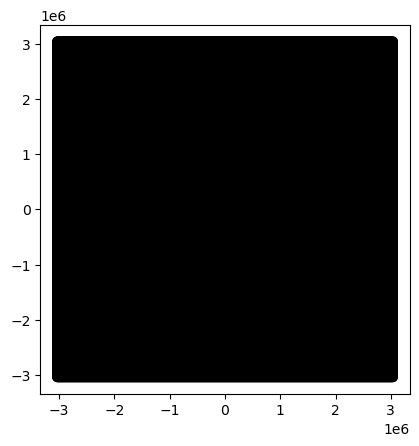

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# basins_gdf.plot(ax=ax, color='none', edgecolor='k')
# lithk_gdf.plot(ax=ax, color='red', markersize=1)
lithk_gdf.plot(ax=ax, color='none', edgecolor='k')
plt.show()

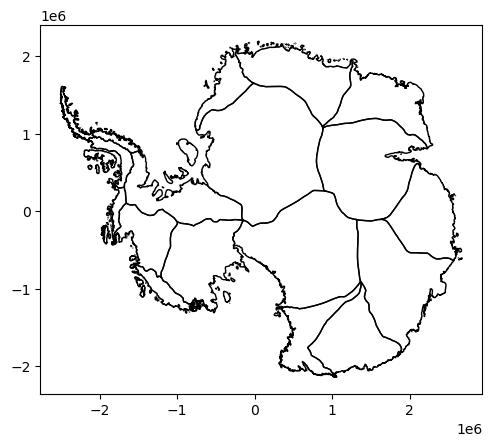

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
basins_gdf.plot(ax=ax, color='none', edgecolor='k')
plt.show()

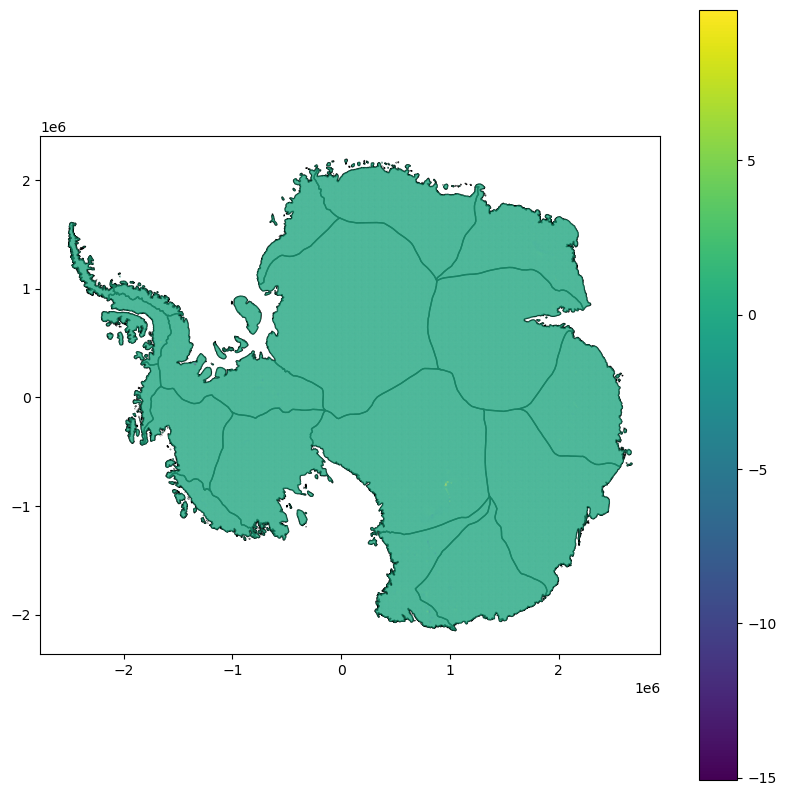

In [7]:
import matplotlib.pyplot as plt

# Plot polygons first
fig, ax = plt.subplots(figsize=(10, 10))
basins_gdf.plot(ax=ax, color='none', edgecolor='black')

# Overlay points with color representing lithk_delta
joined_gdf.plot(ax=ax, column='lithk_delta', cmap='viridis', markersize=0.1, alpha=0.5, legend=True)

plt.show()

In [8]:
import pandas as pd
import numpy as np

# Load the CSV file
csv_file_path = '/home/jovyan/CmCt/notebooks/IMBIE/imbie_greenland_2021_Gt.csv'
mass_balance_data = pd.read_csv(csv_file_path)

# Adjust the column names based on the CSV content
date_column = 'Year'
mass_balance_column = 'Mass balance (Gt/yr)'

# Convert the 'Year' column to datetime format
mass_balance_data[date_column] = pd.to_datetime(mass_balance_data[date_column], format='%Y')

# Filter the data between the start and end dates
start_date = np.datetime64('2000-01-01')
end_date = np.datetime64('2015-01-01')
filtered_data = mass_balance_data[(mass_balance_data[date_column] >= start_date) & 
                                  (mass_balance_data[date_column] <= end_date)].copy()

# Convert Mass balance from Gt/yr to Gt/month
filtered_data.loc[:, 'Mass_balance_Gt'] = filtered_data[mass_balance_column] / 12

# Sum the total mass balance in the filtered range
imbie_total_mass_change_sum = filtered_data['Mass_balance_Gt'].sum()

# Print the results
print(f"Total Mass Balance from {start_date} to {end_date}: {imbie_total_mass_change_sum} Gt")




Total Mass Balance from 2000-01-01 to 2015-01-01: -3299.217333333333 Gt


In [9]:
#Difference of imbie-model  mass change for Greenland
delta_masschange=imbie_total_mass_change_sum-model_total_mass_balance
print(f"Difference of imbie-model  mass change: {delta_masschange}")

Difference of imbie-model  mass change: -2895.4518609212237
